# 02 - MGWR model
This notebook contains the building, training, testing, and validation of a Multiscale Geographically Weighted Regression model te generalise the sound measurements.

In [1]:
# default libs
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
# vector geo data libs
import pandas as pd
import geopandas as gpd
import contextily as cx
# raster geo data libs
import rioxarray as rxr
# audio libs
import soundfile as sf
import waveform_analysis
# OLS
from sklearn import linear_model
import statsmodels.formula.api as smf

import mgwr

# script file, not a module 
import utils

## attempt N at kriging

In [2]:
# gdf = gpd.read_file('..\\output\\distributed_data.GEOJSON', engine='pyogrio', use_arrow=True)
gdf = gpd.read_file('..\\output\\road_dba_gdf.GEOJSON', engine='pyogrio', use_arrow=True)

In [3]:
gdf = gdf[gdf['maxspeed'].notna()]
gdf.columns


Index(['y', 'x', 'dBA_rivm', 'median_speed', 'median_dBA_raw',
       'median_dBA_reg_adj', 'index_right', 'u', 'v', 'key', 'osmid',
       'highway', 'width', 'oneway', 'reversed', 'length', 'name', 'maxspeed',
       'est_width', 'bridge', 'lanes', 'service', 'tunnel', 'access',
       'junction', 'geometry'],
      dtype='object')

In [4]:
# gdf = gdf.clip((136783.0826,451879.0786,138490.1231,453599.2073))

from sklearn.model_selection import train_test_split
gdf_train, gdf_test = train_test_split(gdf[gdf['median_dBA_reg_adj'].notna()], test_size=0.2)
gdf_val = gdf[gdf['median_dBA_reg_adj'].isna()]

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF

kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-2, 1e2))
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=9)
gaussian_process.fit(gdf_train[['x', 'y', 'maxspeed']], gdf_train['median_dBA_reg_adj'])
print(gaussian_process.kernel_)

y_test = gaussian_process.predict(gdf_test[['x', 'y', 'maxspeed']])
score = gaussian_process.score(gdf_test[['x', 'y', 'maxspeed']], gdf_test['median_dBA_reg_adj'])
print(score)

y_val = gaussian_process.predict(gdf_val[['x', 'y', 'maxspeed']])

gdf_train['pred'] = gdf_train['median_dBA_reg_adj']
gdf_test['pred'] = y_test
gdf_val['pred'] = y_val

gdf_pred = pd.concat([gdf_train, gdf_test, gdf_val])


c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\sklearn\gaussian_process\_gpr.py:663: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)


41.3**2 * RBF(length_scale=16.1)
-1.3266205184106914


c:\Users\flori\!projects\noise-these\noise-thesis\.venv\Lib\site-packages\geopandas\geodataframe.py:1528: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


<Axes: >

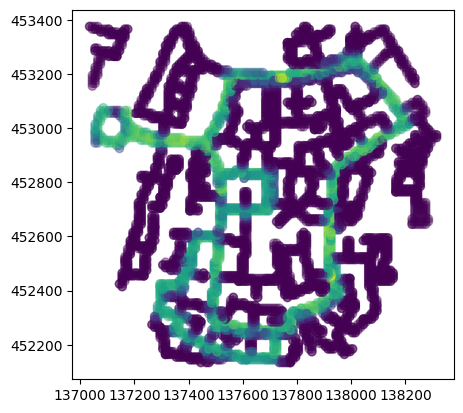

In [8]:
gdf_pred.plot(column='pred', alpha=0.4)

## attempt N at GWR

In [6]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl

In [7]:
list(cal['median_dBA_reg_adj'].apply(lambda x: [x]))

NameError: name 'cal' is not defined

In [ ]:
cal['lanes']

6428       2
4966       1
4020    None
2400    None
2010       2
        ... 
3899    None
57      None
3346    None
3112       2
4060       2
Name: lanes, Length: 672, dtype: object

In [ ]:
cal = gdf_train
cal_coords = np.dstack((cal['x'], cal['y']))[0]
cal_y = np.vstack(cal['median_dBA_reg_adj'])
cal_X = np.dstack((cal['maxspeed'].apply(lambda x: int(x)), cal['lanes'].apply(lambda x: int(x) if x else 1)))[0]
cal_coords

array([[138105., 452965.],
       [137485., 452905.],
       [137505., 452305.],
       ...,
       [137635., 452155.],
       [137725., 453195.],
       [137495., 452355.]])

In [ ]:
print(cal_coords.shape)
print(cal_X.shape)
print(cal_y.shape)

(672, 2)
(672, 2)
(672, 1)


In [ ]:
gwr_selector = Sel_BW(cal_coords, cal_y, cal_X)
gwr_bw = gwr_selector.search(bw_min=100)
print(gwr_bw)
model = GWR(cal_coords, cal_y, cal_X, gwr_bw)
gwr_results = model.fit()

LinAlgError: Matrix is singular.

In [ ]:
scale = gwr_results.scale
residuals = gwr_results.resid_response

pred_results = model.predict(pred_coords, pred_X, scale, residuals)

## MGWR?

In [9]:
import libpysal as ps

from mgwr.gwr import MGWR

from mgwr.sel_bw import Sel_BW

data = ps.io.open(ps.examples.get_path('GData_utm.csv'))

coords = list(zip(data.by_col('X'), data.by_col('Y')))

y = np.array(data.by_col('PctBach')).reshape((-1,1))

rural = np.array(data.by_col('PctRural')).reshape((-1,1))

fb = np.array(data.by_col('PctFB')).reshape((-1,1))

african_amer = np.array(data.by_col('PctBlack')).reshape((-1,1))

X = np.hstack([fb, african_amer, rural])

X = (X - X.mean(axis=0)) / X.std(axis=0)

y = (y - y.mean(axis=0)) / y.std(axis=0)

selector = Sel_BW(coords, y, X, multi=True)


In [13]:

selector.search(multi_bw_min=[2])


Backfitting:   0%|          | 1/200 [00:03<10:43,  3.23s/it]


KeyboardInterrupt: 

In [11]:

model = MGWR(coords, y, X, selector, fixed=False, kernel='bisquare', sigma2_v1=True)

results = model.fit()

print(results.params.shape)

Inference: 100%|██████████| 1/1 [00:00<00:00, 999.83it/s]

(159, 4)


In [12]:
%pip install --upgrade jupyter ipywidgets
%jupyter nbextension enable --py widgetsnbextension 

  Using cached jsonschema_specifications-2023.12.1-py3-none-any.whl.metadata (3.0 kB)
   ---------------------------------------- 0.0/139.4 kB ? eta -:--:--
   ---------------------------------------- 139.4/139.4 kB 8.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/214.4 kB ? eta -:--:--
   --------------------------------------- 214.4/214.4 kB 13.6 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.3 MB ? eta -:--:--
   ---------- ----------------------------- 0.6/2.3 MB 19.8 MB/s eta 0:00:01
   ----------------------- ---------------- 1.4/2.3 MB 17.2 MB/s eta 0:00:01
   --------------------------------- ------ 1.9/2.3 MB 15.4 MB/s eta 0:00:01
   ---------------------------------------- 2.3/2.3 MB 14.9 MB/s eta 0:00:00
   ---------------------------------------- 0.0/257.4 kB ? eta -:--:--
   --------------------------------------- 257.4/257.4 kB 16.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/5.0 MB ? eta -:--:--
   ---- -------

UsageError: Line magic function `%jupyter` not found.


In [14]:
model.predict()

In [16]:
pd.set_option('display.max_columns', None)
gdf

,y,x,dBA_rivm,median_speed,median_dBA_raw,median_dBA_reg_adj,index_right,u,v,key,osmid,highway,width,oneway,reversed,length,name,maxspeed,est_width,bridge,lanes,service,tunnel,access,junction,geometry
0,452135.0,137735.0,53,NaN,NaN,NaN,6,45056618,45056245,0,7012274,living_street,None,False,False,51.776,Chathams,15,None,None,None,None,None,None,None,POINT (137735.000 452135.000)
1,452135.0,137735.0,53,NaN,NaN,NaN,5,45056245,45056618,0,7012274,living_street,None,False,True,51.776,Chathams,15,None,None,None,None,None,None,None,POINT (137735.000 452135.000)
2,452145.0,137685.0,52,NaN,NaN,NaN,7,45056618,366606625,0,32601107,residential,None,False,False,48.437,Filipijnen,30,None,None,None,None,None,None,None,POINT (137685.000 452145.000)
3,452145.0,137685.0,52,NaN,NaN,NaN,750,366606625,45056618,0,32601107,residential,None,False,True,48.437,Filipijnen,30,None,None,None,None,None,None,None,POINT (137685.000 452145.000)
4,452145.0,137705.0,53,NaN,NaN,NaN,7,45056618,366606625,0,32601107,residential,None,False,False,48.437,Filipijnen,30,None,None,None,None,None,None,None,POINT (137705.000 452145.000)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7153,453365.0,138115.0,66,NaN,NaN,NaN,980,4036708676,45105940,0,381722322,residential,None,False,False,41.140,De Wadden,30,None,None,None,None,None,None,None,POINT (138115.000 453365.000)
7154,453365.0,138125.0,69,NaN,NaN,NaN,615,45105940,4036708676,0,381722322,residential,None,False,True,41.140,De Wadden,30,None,None,None,None,None,None,None,POINT (138125.000 453365.000)
7155,453365.0,138125.0,69,NaN,NaN,NaN,980,4036708676,45105940,0,381722322,residential,None,False,False,41.140,De Wadden,30,None,None,None,None,None,None,None,POINT (138125.000 453365.000)
7156,453375.0,138015.0,54,NaN,NaN,NaN,609,45105855,10029764153,0,104487593,residential,None,False,False,26.455,Texel,30,None,None,None,None,None,None,None,POINT (138015.000 453375.000)


In [29]:
import geopandas as gpd
from libpysal.weights import lat2W
from esda.moran import Moran
import numpy as np
# Load your GeoDataFrame
gdf['maxspeed'] = pd.to_numeric(gdf['maxspeed'])
data = gdf[['y', 'x', 'maxspeed', 'median_dBA_raw']].dropna()
# Assuming your_data_array is a 2-D numpy array
your_data_array = np.array([data])[0] # replace with your data
print(your_data_array.shape)
your_data_array

(840, 4)


array([[4.52155000e+05, 1.37665000e+05, 3.00000000e+01, 6.90192542e+01],
       [4.52155000e+05, 1.37715000e+05, 3.00000000e+01, 6.93661349e+01],
       [4.52155000e+05, 1.37715000e+05, 3.00000000e+01, 6.93661349e+01],
       ...,
       [4.53245000e+05, 1.38035000e+05, 5.00000000e+01, 7.64386238e+01],
       [4.53255000e+05, 1.38025000e+05, 5.00000000e+01, 7.99667830e+01],
       [4.53255000e+05, 1.38025000e+05, 5.00000000e+01, 7.99667830e+01]])

In [30]:
w = lat2W(your_data_array.shape[0], your_data_array.shape[1])

In [31]:
mi = Moran(your_data_array, w)

In [32]:
print(f"Moran's I: {mi.I:.4f}")
print(f"p-value: {mi.p_norm:.4f}")
# p < 0.05 thus data is spacially clustered, duhh

Moran's I: 0.7250
p-value: 0.0000


In [33]:
moran_statistic = mi.I